In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Flatten, MaxPooling1D, Conv1D, Input, Dense, Dropout, GlobalAveragePooling1D, Embedding, Layer, MultiHeadAttention, Add, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


In [2]:
# print Tensorflow and CUDA information
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
 
if tf.test.gpu_device_name():
    gpu_devices = tf.config.list_physical_devices('GPU')
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    name = details.get('device_name', 'Unknown GPU')
    
    print(f"Using {name}")
else:
    print("No GPU found")

2023-02-21 01:37:36.595269: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


Num GPUs Available:  1
Num CPUs Available:  1
Tensorflow version: 2.4.1
Keras version: 2.4.0
Using Tesla V100-SXM2-32GB


2023-02-21 01:37:36.596486: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-21 01:37:36.618771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:b3:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-21 01:37:36.618797: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-21 01:37:36.622091: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-21 01:37:36.622129: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-02-21 01:37:36.625020: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.

In [3]:
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

In [4]:
%%time
numberbatch_embeddings = load_embeddings("embeddings/numberbatch-en-17.04b.txt")
numberbatch_embeddings.shape

EMBED_SIZE = numberbatch_embeddings.shape[1]

CPU times: user 28 s, sys: 871 ms, total: 28.9 s
Wall time: 29.1 s


In [145]:
labeled_content = pd.read_csv('data/labeled_headlines.csv')
labeled_content = labeled_content[labeled_content['score'] != 0]

#concatenate title and first 256 words in content in one column
# labeled_content['title_content'] = labeled_content['title'].astype(str) + ' ' + labeled_content['content'].astype(str).str[:256]


X = labeled_content['title'].astype(str).values
y = labeled_content['score'].values
                                #.astype('float32')

In [146]:
NUM_TOP_WORDS = None # use entire vocabulary!
MAX_TITLE_LEN = 32 # maximum and minimum number of words
NUM_CLASSES = 2

tokenizer = Tokenizer(
                    num_words=NUM_TOP_WORDS,
                    filters = '—!"“”#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t…\'‘’'
                     )

tokenizer.fit_on_texts(X)

sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))

X = pad_sequences(sequences, maxlen=MAX_TITLE_LEN)

y = np.where(y == -1, 0, 1)

# y = keras.utils.to_categorical(y, num_classes=NUM_CLASSES)

print(f"Found {len(word_index):,} unique tokens. Distilled to {top_words:,} top words.")



# now fill in the matrix, using the ordering from the
# keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))

for word, i in word_index.items():
    
    try:
        embedding_vector = numberbatch_embeddings.loc[word]
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1
    except:
        #print(word)
        pass


print(f"Embedding Shape: {embedding_matrix.shape}")
print(f"Total words found: {found_words:,}")
print(f"Percentage: {round(100 * found_words / embedding_matrix.shape[0], 2)}")

Found 12,013 unique tokens. Distilled to 12,013 top words.
Embedding Shape: (12014, 300)
Total words found: 11,346
Percentage: 94.44


In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=402)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (6958, 32)
X_test shape: (1740, 32)
y_train shape: (6958,)
y_test shape: (1740,)


In [148]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_TITLE_LEN,
                            trainable=False)

class PositionalEncoding(Layer):
    def __init__(self, max_len, embedding_dim, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.max_len = max_len
        self.embedding_dim = embedding_dim

    def call(self, inputs):
        positions = tf.range(start=0, limit=self.max_len, delta=1)
        positions = tf.cast(positions, tf.float32)
        positions = tf.expand_dims(positions, axis=-1)
        pos_encoding = inputs + (positions / 10000 ** (2 * (positions // 2) / self.embedding_dim))
        return pos_encoding

In [149]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [175]:
embed_dim = EMBED_SIZE  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 16  # Hidden layer size in feed forward network inside transformer
num_trans = 3

d_model = 300
dff=2048

inputs = Input(shape=(MAX_TITLE_LEN,), dtype=tf.int32)
embedding = embedding_layer(inputs)
pos_encoding = PositionalEncoding(MAX_TITLE_LEN,embed_dim)
x = pos_encoding(embedding)

## self-attention
query = tf.keras.layers.Dense(d_model)(x)
value = tf.keras.layers.Dense(d_model)(x)
key = tf.keras.layers.Dense(d_model)(x)
attention = tf.keras.layers.Attention()([query, value, key])
attention = tf.keras.layers.Dense(d_model)(attention)
x = tf.keras.layers.Add()([x , attention]) # residual connection
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

## Feed Forward
dense = tf.keras.layers.Dense(dff, activation='relu')(x)
dense = tf.keras.layers.Dense(d_model)(dense)
x = tf.keras.layers.Add()([x , dense])     # residual connection
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

x = GlobalAveragePooling1D()(x)

x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 32, 300)      3604200     input_53[0][0]                   
__________________________________________________________________________________________________
positional_encoding_23 (Positio (None, 32, 300)      0           embedding_9[8][0]                
__________________________________________________________________________________________________
dense_218 (Dense)               (None, 32, 300)      90300       positional_encoding_23[0][0]     
___________________________________________________________________________________________

In [182]:
inputs = Input(shape=(MAX_TITLE_LEN,), dtype=tf.int32)
embedding = embedding_layer(inputs)

# Add a 1D Convolutional layer
conv1d = Conv1D(filters=32, kernel_size=3, activation='relu')(embedding)

# Add a Max Pooling layer
pooling = MaxPooling1D(pool_size=2)(conv1d)

# Flatten the output of the Max Pooling layer
flatten = Flatten()(pooling)

dense = Dense(units=64, activation='sigmoid')(flatten)
dense = Dense(units=32, activation='sigmoid')(dense)

# Add a Dense output layer with a single neuron and a sigmoid activation function
outputs = Dense(units=1, activation='sigmoid')(dense)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        [(None, 32)]              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 32, 300)           3604200   
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 30, 32)            28832     
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 15, 32)            0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 480)               0         
_________________________________________________________________
dense_228 (Dense)            (None, 64)                30784     
_________________________________________________________________
dense_229 (Dense)            (None, 32)                208

In [183]:
# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=2048, epochs=64)
# TODO: see how big we can make the batch size
# probably very large when using the V100's

Epoch 1/64
4/4 [==============================] - 1s 73ms/step - loss: 0.7055 - accuracy: 0.5025 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/64
4/4 [==============================] - 0s 37ms/step - loss: 0.6905 - accuracy: 0.5509 - val_loss: 0.6886 - val_accuracy: 0.5000
Epoch 3/64
4/4 [==============================] - 0s 36ms/step - loss: 0.6882 - accuracy: 0.4977 - val_loss: 0.6847 - val_accuracy: 0.5000
Epoch 4/64
4/4 [==============================] - 0s 37ms/step - loss: 0.6829 - accuracy: 0.5014 - val_loss: 0.6748 - val_accuracy: 0.5724
Epoch 5/64
4/4 [==============================] - 0s 37ms/step - loss: 0.6716 - accuracy: 0.6443 - val_loss: 0.6615 - val_accuracy: 0.8126
Epoch 6/64
4/4 [==============================] - 0s 37ms/step - loss: 0.6580 - accuracy: 0.7990 - val_loss: 0.6448 - val_accuracy: 0.7925
Epoch 7/64
4/4 [==============================] - 0s 36ms/step - loss: 0.6409 - accuracy: 0.7844 - val_loss: 0.6208 - val_accuracy: 0.8218
Epoch 8/64
4/4 [===========

4/4 [==============================] - 0s 37ms/step - loss: 0.1649 - accuracy: 0.9570 - val_loss: 0.2470 - val_accuracy: 0.9052
Epoch 60/64
4/4 [==============================] - 0s 36ms/step - loss: 0.1578 - accuracy: 0.9588 - val_loss: 0.2487 - val_accuracy: 0.9034
Epoch 61/64
4/4 [==============================] - 0s 37ms/step - loss: 0.1557 - accuracy: 0.9589 - val_loss: 0.2484 - val_accuracy: 0.9040
Epoch 62/64
4/4 [==============================] - 0s 37ms/step - loss: 0.1531 - accuracy: 0.9592 - val_loss: 0.2487 - val_accuracy: 0.9034
Epoch 63/64
4/4 [==============================] - 0s 37ms/step - loss: 0.1471 - accuracy: 0.9618 - val_loss: 0.2547 - val_accuracy: 0.9000
Epoch 64/64
4/4 [==============================] - 0s 36ms/step - loss: 0.1479 - accuracy: 0.9605 - val_loss: 0.2475 - val_accuracy: 0.9063


In [184]:
def plot_history(history, name="Results"):
    # plot f1 score, loss, and accuracy for training and validation together
    plt.figure(figsize=(20, 5))
 
    plt.subplot(1,2,1)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.title('Loss')
    plt.legend(['Train', 'Test'], loc='best')
 
    plt.subplot(1,2,2)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('epochs')
    plt.title('Accuracy')
    plt.legend(['Train', 'Test'], loc='best')
 
    # set the title for the whole figure
    plt.suptitle(name, fontsize=16)
 
    plt.show()

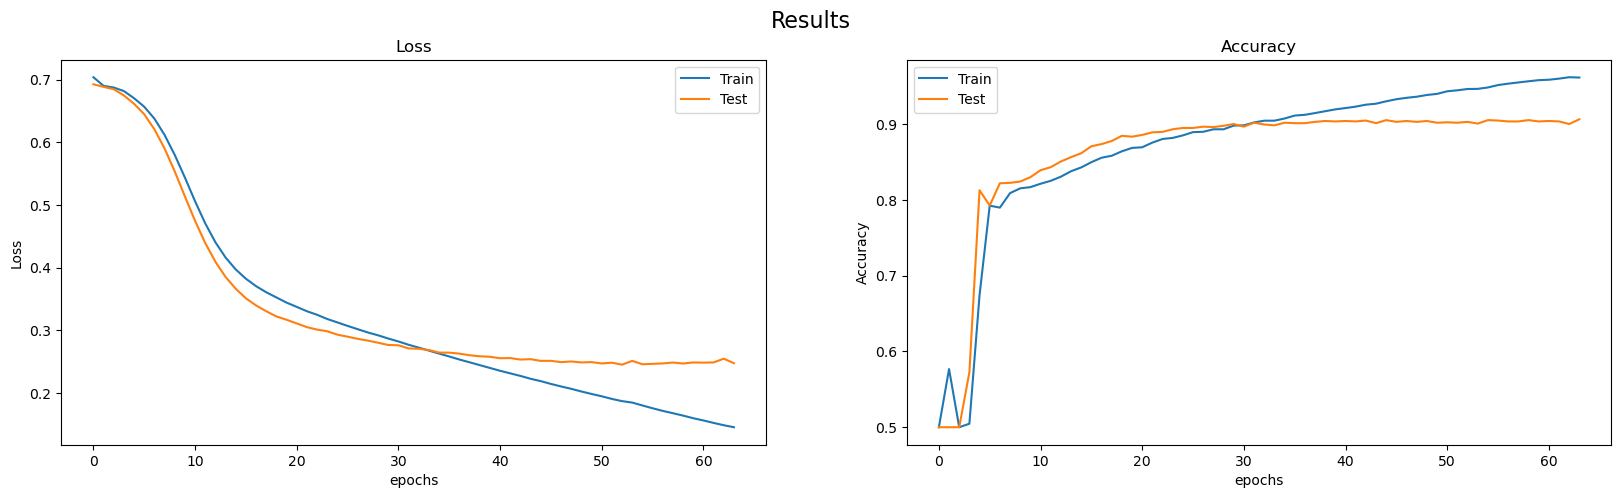

In [185]:
plot_history(model.history.history)

In [186]:
y_pred = model.predict(X_test)

In [187]:
for i in range(1500):
    print(f"Predicted: {y_pred[i]}")
    print(f"Actual: {y_test[i]}")
    
    

Predicted: [0.97898203]
Actual: 1
Predicted: [0.89545625]
Actual: 1
Predicted: [0.01052587]
Actual: 0
Predicted: [0.02635019]
Actual: 0
Predicted: [0.03759607]
Actual: 0
Predicted: [0.98713416]
Actual: 1
Predicted: [0.01438653]
Actual: 0
Predicted: [0.05818545]
Actual: 0
Predicted: [0.93241584]
Actual: 1
Predicted: [0.01539334]
Actual: 0
Predicted: [0.04268327]
Actual: 0
Predicted: [0.8466173]
Actual: 1
Predicted: [0.43464255]
Actual: 0
Predicted: [0.01859074]
Actual: 0
Predicted: [0.16410945]
Actual: 0
Predicted: [0.97235596]
Actual: 1
Predicted: [0.9326821]
Actual: 1
Predicted: [0.9876051]
Actual: 1
Predicted: [0.01153906]
Actual: 0
Predicted: [0.05575741]
Actual: 0
Predicted: [0.96855617]
Actual: 1
Predicted: [0.01870491]
Actual: 0
Predicted: [0.94455224]
Actual: 1
Predicted: [0.01446966]
Actual: 0
Predicted: [0.02501189]
Actual: 0
Predicted: [0.02606459]
Actual: 0
Predicted: [0.9853474]
Actual: 1
Predicted: [0.85733944]
Actual: 0
Predicted: [0.6230711]
Actual: 0
Predicted: [0.98136